<left>
    <h2> Text Mining  </h2>
    <h3> Exercise 3 </h3>
    <h4> Professor: Nandan </h4>
    <h4> Author: Kostis </h4>
</center>

In [217]:
'''Libraries'''
import pandas as pd

import seaborn as sns

import regex as re

from functools import reduce

import multiprocessing

from bs4 import BeautifulSoup

import spacy

from gensim.models import Word2Vec

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from scipy.spatial.distance import pdist,squareform

import warnings
warnings.filterwarnings("ignore")

In [298]:
'''Datasets'''
# Yelp
yelps = pd.read_csv('sentiment/yelps.csv').sample(frac=1).reset_index(drop=True)

# Tweeter
with open('tweets/tweets.txt') as f:
    tweets = pd.Series(f.readlines())

### Yelp

In [197]:
'''Clean and tokenize'''

def clean_yelp(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    """ Returns a list of strings (tokens) from the document """
    # define and compile pattern, then return expressions that match pattern
    token_pattern = re.compile(r"(?u)\b\w\w+\b")
    return token_pattern.findall(s)
    
    # Implement this function!
    # Hint: If you look at the sklearn source code on github, 
    # you will find a good regular expression they use as a default
    # tokenizer in CountVectorizer -- this is the tokenizer
    # we have been using until now!
    # But you need to implement your own now. 

In [198]:
# Create a count vectorizer, using the preprocessor and tokenizer from above
# use TruncatedSVD from Sklearn to generate a term embedding matrix for your data
# that is 100 dimensional in size.
# Embed your documents via that term embedding matrix (this is just the PCA of the 
# TF matrix, as returned by "transform" on TruncatedSVD

# Here you should have TWO vector representations of your Yelp data: 
# 1. The original TF matrix
# 2. The first 100 components of the PCA of that matrix, as performed by TruncatedSVD

#### Vector Representations

In [299]:
'''TF Representation'''
TF = CountVectorizer(preprocessor= clean_yelp, tokenizer=tokenize)
V_TF = TF.fit_transform(yelps.text)

In [300]:
'''PCA (100 components)'''
SVD = TruncatedSVD(n_components=100)
V_SVD = SVD.fit_transform(V_TF)

In [301]:
'''w2v'''
# use the embed_w2v function to embed your Yelp reviews using the new
# word2vec word embeddings. Each review will be a normalized sum of the
# words that it is made of. 
# See how this improves the scores in the classification task using
# test_holdout_vectors -- is word2vec better? At what training-set sizes does it help
# more? 
cores = multiprocessing.cpu_count()
sentences = pd.Series([])
for val in yelps.text:
    sentences =sentences.append(pd.Series([tokenize(clean_yelp(val))]))

w2v = Word2Vec(size=150, window=2, alpha=0.02, 
               min_alpha=0.0006, workers= cores-1)

w2v.build_vocab(sentences)
w2v.train(sentences, total_examples=w2v.corpus_count, epochs=30)

def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0)
    a /= np.linalg.norm(a)
    return a

In [302]:
'''Test different vector Representations'''
# Test your vector representations using the above function, test_holdout_vectors. 
# for several levels of "cutoff". 

# This function simulates training on a small part of your data and testing on the rest.
# Thus, it's as though you have some labelled data but a bunch of unlabelled data. 
# This is essentially a semi-supervised situation. 

# Do the word embeddings generated via SVD allow you to pull information from the 
# unlabeled data and improve your score given a small training set? 

def test_holdout_vectors(V, y, cutoff):
    model = LogisticRegression()
    model.fit(V[:cutoff], y[:cutoff])
    preds = model.predict(V[cutoff:])
    return accuracy_score(preds, y[cutoff:])

In [303]:
'''Test SVD - 5 cuts'''
i = 20
while i <= V_SVD.shape[1]:
    print("Cut:", i, "- Accuracy:",test_holdout_vectors(V_SVD, yelps.positive, i))
    i += 20

Cut: 20 - Accuracy: 0.6930786157231447
Cut: 40 - Accuracy: 0.6954481792717087
Cut: 60 - Accuracy: 0.7229337602561537
Cut: 80 - Accuracy: 0.7621897518014411
Cut: 100 - Accuracy: 0.7862962962962963


In [304]:
'''Test TF - 5 same cuts as SVD'''
i = 20
while i <= V_SVD.shape[1]:
    print("Cut:", i, "- Accuracy:", test_holdout_vectors(V_TF, yelps.positive, i))
    i += 20

Cut: 20 - Accuracy: 0.67625525105021
Cut: 40 - Accuracy: 0.7092937174869948
Cut: 60 - Accuracy: 0.7374524714828897
Cut: 80 - Accuracy: 0.7748498799039232
Cut: 100 - Accuracy: 0.8050850850850851


In [305]:
'''Test TF - 5 cuts'''
i = 15674
while i <= V_TF.shape[1]:
    print("Cut:", i, "- Accuracy:",test_holdout_vectors(V_TF, yelps.positive, i))
    i += 15674

Cut: 15674 - Accuracy: 0.9521974242819534
Cut: 31348 - Accuracy: 0.9564470080988172
Cut: 47022 - Accuracy: 0.9592283589414474
Cut: 62696 - Accuracy: 0.9606476517263565
Cut: 78370 - Accuracy: 0.9601941747572815


In [306]:
'''Test w2v - 5 same cuts as TF'''
i = 15674
while i <= V_TF.shape[1]:
    print("Cut:", i, "- Accuracy:",test_holdout_vectors(np.array([embed_w2v(t, w2v) for t in sentences]), yelps.positive, i))
    i += 15674

Cut: 15674 - Accuracy: 0.9424258235894031
Cut: 31348 - Accuracy: 0.9463963176600827
Cut: 47022 - Accuracy: 0.9482426667673374
Cut: 62696 - Accuracy: 0.9487990564014583
Cut: 78370 - Accuracy: 0.946925566343042


__Coment:__ As expected, we get better accuracy when we use the whole feature space (TF 5 same cuts as SVD vs. TF 5 cuts whole space). For the cuts that we defined for SVD, SVD performs better than FT (SVD 5 cuts vs TF 5 same cuts as SVD). Last, for the whole sample, TF works slightly better than w2v.

### Tweeter

In [243]:
# TODO: Use regular expressions to remove unwanted
# text and clean up our tweets to be more usable!

# BONUS: Try using the library "spacy" to 
# do further processing, such as lemmatizing
# or replacing Named Entities with constants (i.e. "[NAMED]")
# or adding the part of speech or dependency code to the word 

nlp = spacy.load("en")
pats = [re.compile(r'https?:\/\/[^\s]+'), 
        re.compile(r'rt\s*@\w+\s?:?'),
        re.compile(r'@\w+')]

def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """       
    # Remove Emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    s = emoji_pattern.sub(r'', str(s)) # no emoji
    
    s = re.sub("RT*","", str(s)) # Remove Retweets RT
    s = re.sub("@\S*","", str(s)) # Remove users and mentions
    s = re.sub("http\S*","", str(s)) # Remove links
    s = re.sub('[#-:;,.?\'""!\s]',' ', str(s)) # remove special caracters
    
    doc = nlp(s) # using spacy
    s = ' '.join([token.lemma_ for token in doc]) #lemmatizing
    
    s = s.lower() # lower case
    
    _sub = lambda s,pat: re.sub(pat, '', s)
    s = reduce(_sub, pats, s)
    s = ' '.join(s.split()).strip()
    return s

In [245]:
'''Sample of 10000 tweets'''
tweets_sample = tweets.sample(10000)

In [246]:
# Now embed this twitter data, again using Word2Vec and LSA (SVD)
# you don't have any labels, but you might be able to 
# find some interesting phenomena. 

# Explore using either or both of the following tools: 
# 1. Word2Vec has a built in feature for getting most similar
# words, including via positive/negative examples (subtraction)
# What happens when you subtract "hillary" from "trump"? 
# 
# Bonus: build a similar feature for your LSA features and
# see if you can do similar vector math

# 2. Use the visualize_dist function to see how
# the tweet-tweet distance looks for a selection
# of random tweets. Do you agree with the distance? 
# Does one embedding seem better than another? 

# TF Representation
TF_tweet = CountVectorizer(preprocessor = clean_twitter)
V_TF_tweet = TF_tweet.fit_transform(tweets_sample)

In [247]:
# PCA (100 components)
SVD_tweet = TruncatedSVD(n_components=100)
V_SVD_tweet = SVD_tweet.fit_transform(V_TF_tweet)

In [248]:
# w2v
sentences_tweet = [clean_twitter(val).split(' ') for val in tweets_sample]
w2v = Word2Vec(sentences_tweet, workers=5)
w2v_tweet = np.array([embed_w2v(val, w2v) for val in sentences_tweet])

In [251]:
'''Similarity using w2v'''
# Trump
w2v.wv.most_similar("trump")

[('feel', 0.9972110986709595),
 ('in', 0.9971967339515686),
 ('year', 0.9971141815185547),
 ('up', 0.9968377351760864),
 ('help', 0.9967727661132812),
 ('at', 0.9967682361602783),
 ('try', 0.9967376589775085),
 ('ready', 0.996721088886261),
 ('of', 0.9967142343521118),
 ('with', 0.9966156482696533)]

In [254]:
# Hillary
w2v.wv.most_similar('hillary')

[('obama', 0.9977563619613647),
 ('let', 0.9967739582061768),
 ('call', 0.9960373044013977),
 ('clinton', 0.9957067966461182),
 ('time', 0.9950782060623169),
 ('here', 0.9948357939720154),
 ('an', 0.9946215748786926),
 ('amp', 0.9929739236831665),
 ('back', 0.9928981065750122),
 ('nothing', 0.9928711652755737)]

In [263]:
# Trump - woman
w2v.wv.most_similar(positive=['trump'], negative=['woman'])

[('america', 0.30934664607048035),
 ('disgust', 0.24121180176734924),
 ('hat', 0.18912656605243683),
 ('schumerdacashutdown', 0.18794432282447815),
 ('schumershutdown', 0.18026074767112732),
 ('don', 0.17978879809379578),
 ('schumersurrender', 0.17962902784347534),
 ('schumersellout', 0.17772117257118225),
 ('do', 0.17719072103500366),
 ('if', 0.16778846085071564)]

In [267]:
# Hillary - Trump
w2v.wv.most_similar(positive=['hillary'], negative=['trump'])

[('s', 0.6638202667236328),
 ('today', 0.6417021751403809),
 ('on', 0.5992355346679688),
 ('lesson', 0.5919530391693115),
 ('islam', 0.5508599281311035),
 ('fuckislamicextremism', 0.5450016260147095),
 ('nothinggoodcomesfromislam', 0.4895938038825989),
 ('evillosers', 0.46239739656448364),
 ('theplan', 0.44678831100463867),
 ('moslemsarentpeaceful', 0.44576582312583923)]

__Coment:__ We get reasonable results in most w2v featuresl. For instance, Hillary seems very related with Obama and Clinton, while if we subtract woman from Trump we get disgust.  

In [290]:
def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap

    V is the vector of embeddings 
    tweets is a list or series that converts from idx to tweet
    idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]),xticklabels=False, cmap='Blues')

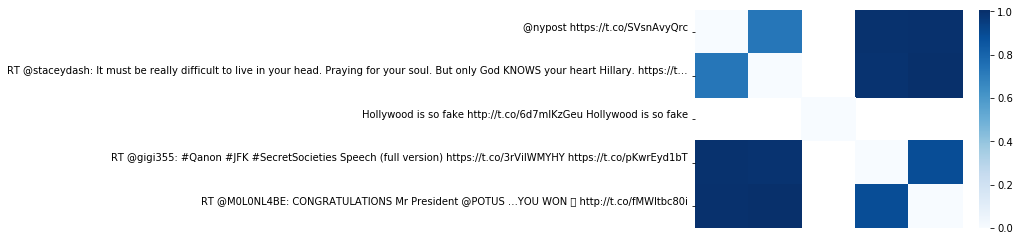

In [296]:
# SVD Visualization
idxs = np.random.randint(len(tweets_sample), size=5)
visualize_dist(V_SVD_tweet, tweets, idxs)

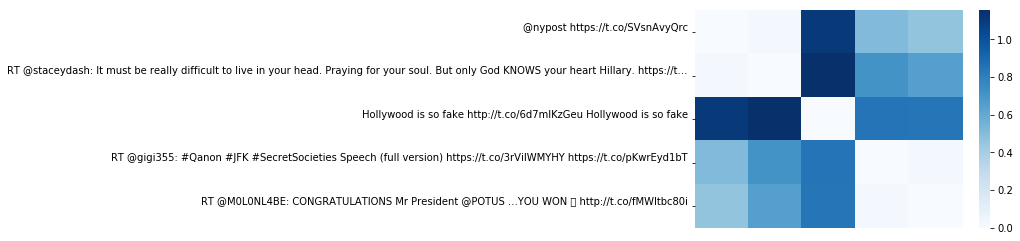

In [297]:
# w2v Visualization
visualize_dist(w2v_tweet, tweets, idxs)

__Comment__: Visualization for SVD and w2v produces similar results, as happened with the yelp data.